In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [6]:
dataset_path = "dataset_amyloid.pickle"
with open(dataset_path, 'rb') as f:
    X_train, y_train, X_test, y_test = pickle.load(f)
X = np.concatenate((X_train, X_test), axis=0)
Y = np.concatenate((y_train, y_test), axis=0)

In [7]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.astype(np.float32)  # 注意改为 float32 以匹配 PyTorch 的默认浮点类型

X_tensor = torch.FloatTensor(X_scaled)

label_encoder = LabelEncoder()
Y_numerical = label_encoder.fit_transform(Y)



In [8]:
class Array_Encoder(nn.Module):
    def __init__(self, output_size, input_size):
        super(Array_Encoder, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, output_size),
            nn.BatchNorm1d(output_size),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.fc(x)

class Array_Decoder(nn.Module):
    def __init__(self, embedding_size, output_size):
        super(Array_Decoder, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(embedding_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, output_size),
            nn.Sigmoid()  # 使用Sigmoid激活函数确保输出在[0, 1]范围内
        )

    def forward(self, x):
        return self.fc(x)

class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(Autoencoder, self).__init__()

        self.encoder = Array_Encoder(output_size=encoding_dim, input_size=input_size)
        self.decoder = Array_Decoder(embedding_size=encoding_dim, output_size=input_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [9]:
input_size = X_tensor.shape[1]
encoding_dim = 64
model = Autoencoder(input_size=input_size, encoding_dim=encoding_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [10]:
# 训练循环
num_epochs = 20
for epoch in range(num_epochs):
    # 前向传播
    outputs = model(X_tensor)
    loss = criterion(outputs, X_tensor)

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/20], Loss: 0.2473
Epoch [2/20], Loss: 0.1887
Epoch [3/20], Loss: 0.1134
Epoch [4/20], Loss: 0.0658
Epoch [5/20], Loss: 0.0401
Epoch [6/20], Loss: 0.0238
Epoch [7/20], Loss: 0.0162
Epoch [8/20], Loss: 0.0125
Epoch [9/20], Loss: 0.0106
Epoch [10/20], Loss: 0.0098
Epoch [11/20], Loss: 0.0094
Epoch [12/20], Loss: 0.0092
Epoch [13/20], Loss: 0.0091
Epoch [14/20], Loss: 0.0090
Epoch [15/20], Loss: 0.0090
Epoch [16/20], Loss: 0.0089
Epoch [17/20], Loss: 0.0089
Epoch [18/20], Loss: 0.0089
Epoch [19/20], Loss: 0.0088
Epoch [20/20], Loss: 0.0088


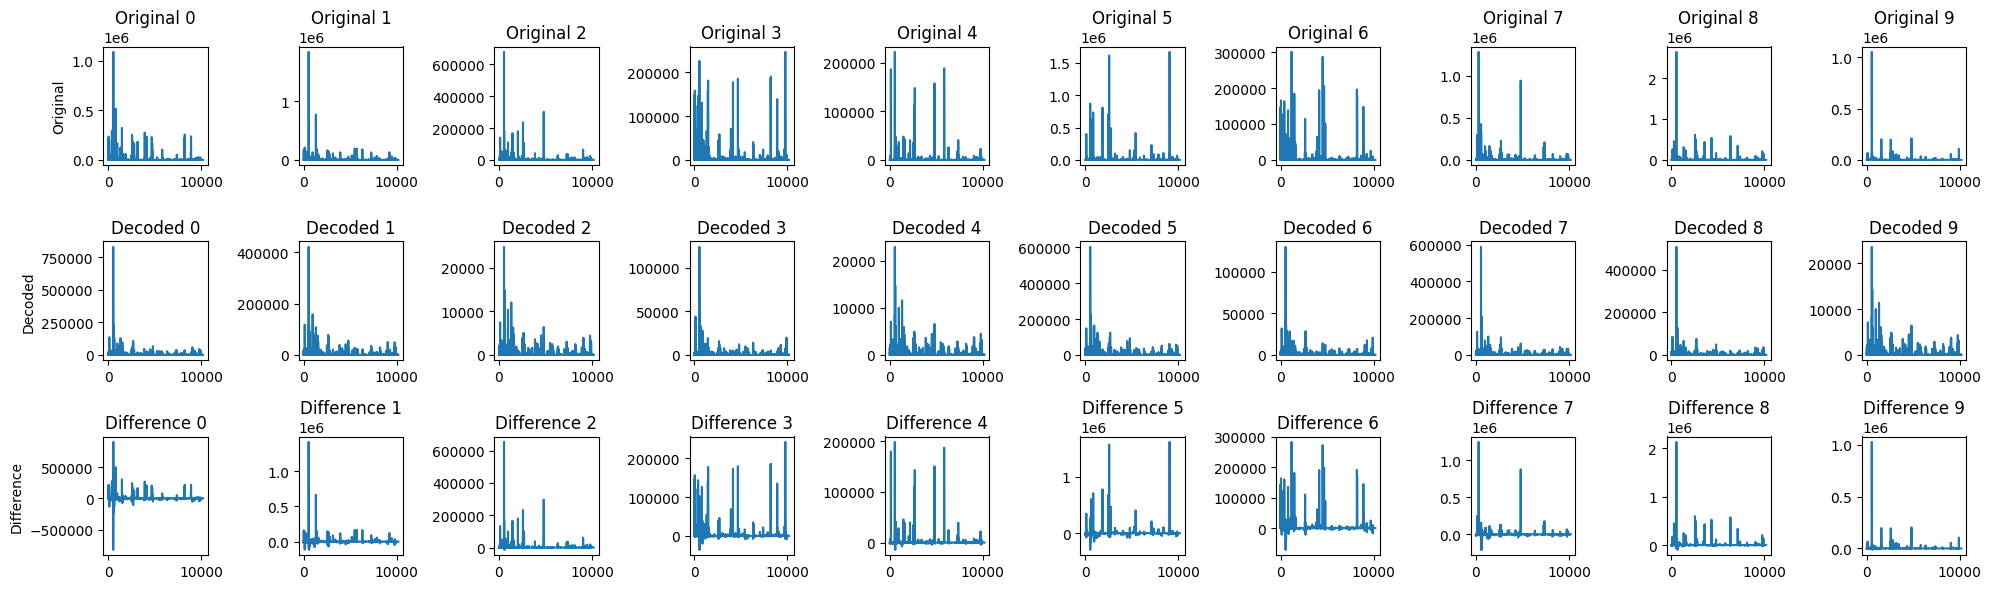

In [11]:
# 反归一化
outputs_np = outputs.detach().numpy()
decoded_data = scaler.inverse_transform(outputs_np)

# 可视化
import matplotlib.pyplot as plt

# 计算差异
difference = X - decoded_data

# 可视化函数
def visualize_data(original, decoded, difference, num_samples=10):
    fig, axes = plt.subplots(nrows=3, ncols=num_samples, figsize=(20, 6))
    
    for i in range(num_samples):
        # 原始数据
        axes[0, i].plot(original[i])
        axes[0, i].set_title(f'Original {i}')
        
        # 解码数据
        axes[1, i].plot(decoded[i])
        axes[1, i].set_title(f'Decoded {i}')
        
        # 差异
        axes[2, i].plot(difference[i])
        axes[2, i].set_title(f'Difference {i}')
    
    axes[0, 0].set_ylabel('Original')
    axes[1, 0].set_ylabel('Decoded')
    axes[2, 0].set_ylabel('Difference')
    plt.tight_layout()
    plt.savefig('Comparison_OriDeDif.png')
    plt.show()

# 可视化
visualize_data(X, decoded_data, difference)
